# Figures

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(0, '../')
import mut.stats
import mut.thermo
import mut.viz
pboc_colors = mut.viz.color_selector('pboc')
mut_colors = mut.viz.color_selector('mut')
mut.viz.plotting_style()
%matplotlib inline

## Parsing and cleaning of data

In [8]:
data = pd.read_csv('../data/csv/compiled_data.csv')

##  Figure 2 - DNA Binding Energy via Leakiness Measurements

In [11]:
# Isolate 
DNA_data = data[(data['class'] != 'IND') & (data['operator'] == 'O2') &
                (data['class'] != 'DBL')]

# Compute the mean and error for points. 
DNA_mean_sem = pd.DataFrame(DNA_data.groupby(['mutant', 'repressors', 
                          'IPTGuM']).apply(mut.stats.compute_mean_sem)).reset_index()

# Load sampling data
samples = pd.read_csv('../data/csv/DNA_binding_energy_samples.csv')

/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1e-07, right=1e-07
  'left=%s, right=%s') % (left, right))
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1e-07, right=1e-07
  'left=%s, right=%s') % (left, right))


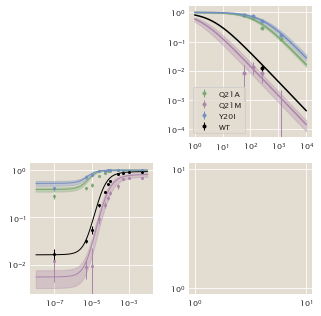

In [24]:
# Instantiate the figure canvas. 
fig, ax = plt.subplots(2, 2, figsize=(4.5, 4.5))

# Format the appropriate axes. 
ax[0,0].set_axis_off()
ax[0, 1].set_yscale('log')

for a in ax.ravel():
    a.set_xscale('log')
    a.set_yscale('log')
    a.xaxis.set_tick_params(labelsize=8)
    a.yaxis.set_tick_params(labelsize=8)

#

# Compute the most-likely parameter values for DNA binding energy
muts = DNA_data['mutant'].unique()
mode = samples.iloc[np.argmax(samples['logp'].values)]

# Define the repressor copy number range for plotting 
rep_range = np.logspace(0, 4, 500)
for i, m in enumerate(muts):
    if m == 'wt':
        ep_RA = -13.9
        color='k'
    else:
        ep_RA = mode['ep_RA.{}'.format(m)]
        color=mut_colors[m]

        
    # Compute the best fit line
    best_fit = mut.thermo.SimpleRepression(rep_range, ep_r=ep_RA, effector_conc=0, ep_ai=4.5, 
                n_sites=2, ka=1, ki=1).fold_change()
    ax[0,1].plot(rep_range, best_fit,  color=color)   
        
    # Compute the credible regions.
    if m != 'wt':
        cred_region = np.zeros((2, len(rep_range)))
        for j, r in enumerate(rep_range):
            cred = mut.thermo.SimpleRepression(r, ep_r=samples['ep_RA.{}'.format(m)], effector_conc=0,
                                              ep_ai=4.5, n_sites=2, ka=1, ki=1).fold_change()
            cred_region[:, j] = mut.stats.compute_hpd(cred, mass_frac=0.95)
        
        # Plot the shaded credible regions.
        _ = ax[0, 1].fill_between(rep_range, cred_region[0, :], cred_region[1, :], 
                                  color=mut_colors[m], alpha=0.3)

# Plot the leakiness, and titration data. 
grouped = DNA_mean_sem[DNA_mean_sem['IPTGuM']==0].groupby('mutant')
for g, d in grouped:
    if g== 'wt':
        label='WT'
        color='k'
    else:
        label=g
        color=mut_colors[g]
    _ = ax[0, 1].errorbar(d['repressors'], d['mean'], d['sem'], fmt='.', linestyle='none',
                     lw=1, color=color, label=label)
_ = ax[0, 1].legend(fontsize=8, ncol=1, loc='lower left')
plt.tight_layout()


# Plot the IPTG induction curves. 
c_range = np.logspace(-8, -2, 500)

for g, d in DNA_mean_sem[DNA_mean_sem['repressors']==260].groupby(['mutant', 'IPTGuM']):
    if g[0] == 'wt':
        label = 'WT'
        color = 'k'
    else:
        label = g[0]
        color = mut_colors[g[0]]
    ax[1, 0].errorbar(d['IPTGuM'] / 1E6, d['mean'], d['sem'], lw=1, linestyle='none',
                     fmt='.', color=color, label=label, ms=4)
   
for i, m in enumerate(muts):
    if m == 'wt':
        ep_RA=-13.9
        color='k'
    else:
        ep_RA = mode['ep_RA.{}'.format(m)]
        color = mut_colors[m]
    
    best_fit = mut.thermo.SimpleRepression(R=260, ep_r=ep_RA, ka=139E-6, ki=0.53E-6, effector_conc=c_range,
                                          ep_ai=4.5, n_sites=2).fold_change()
    
    if m!='wt': 
        # Compute the credible regions. 
        cred_region = np.zeros((2, len(c_range)))
        for j, c in enumerate(c_range):
            cred = mut.thermo.SimpleRepression(R=260, ep_r=samples['ep_RA.{}'.format(m)], effector_conc=c,
                                              ka=139E-6, ki=0.53E-6, n_sites=2, ep_ai=4.5).fold_change()
            cred_region[:, j] = mut.stats.compute_hpd(cred, 0.95)
        ax[1, 0].fill_between(c_range, cred_region[0, :], cred_region[1, :], alpha=0.3, color=mut_colors[m]) 
        
    ax[1, 0].plot(c_range, best_fit, lw=1, color=color)
    